# Tutorial 2: Application of AlignDG on real spatial transcriptomics data (DLPFC)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import anndata as ad
import scanpy as sc
import pandas as pd
import os
import numpy as np
from scipy import sparse
import torch
import aligndg

# set seed as 42
aligndg.set_global_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')

In [2]:
# get cuda version (oue device is 12, some new device may be 13)
! nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


### Check jax device on cuda or cpu. If you hava cuda device and result is cpu, please consider: pip install --upgrade "jax[cuda12]". (cuda version can be 12 or 13)

In [14]:
import jax

jax.default_backend(), device

('gpu', device(type='cuda', index=0))

In [4]:
from aligndg.utils import graph_construction

section_ids = ['151673', '151674']

adata_list = []
adj_list = []

for section_id in section_ids:
    input_dir ='/root/data/DLPFC'
    adata = sc.read_h5ad(os.path.join(input_dir, section_id + '_preprocessed.h5'))
    adata.var_names_make_unique()
    adata.obs_names = [x + '_' + section_id for x in adata.obs_names]
        
    sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=10000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]
    graph_construction.cal_spatial_network(adata, model='KNN', k_cutoff=6)
    
    adj_list.append(adata.uns['adj'])
    adata_list.append(adata)

Calculating spatial neighbor graph ...
The graph contains 23691 edges, 3611 cells
6.5607864857380225 neighbors per cell on average
Calculating spatial neighbor graph ...
The graph contains 23721 edges, 3635 cells
6.525722145804677 neighbors per cell on average


In [5]:
from scipy.sparse import block_diag

adata_concat = ad.concat(adata_list, label='slice_name', keys=section_ids)
adj_concat = block_diag(adj_list)
adata_concat.uns['edge_list'] = np.nonzero(adj_concat)

In [6]:
from aligndg.graph import AlignDG

iter_comb = [(0, 1)]
adata_concat, pis = AlignDG.train_AlignDG(adata=adata_concat, lamb=2, beta=0.4, iter_comb=iter_comb)

  0%|          | 0/500 [00:00<?, ?it/s]

Update spot triplet at epoch 500
Processing datasets ('151673', '151674')
Solver may not converge.


# Epoch 599, loss: 0.183, gene_recon: 0.182, triplet loss: 0.000783044786658138:  19%|█▉        | 97/500 [00:16<00:08, 47.63it/s]  

Update spot triplet at epoch 600
Processing datasets ('151673', '151674')
Solver may not converge.


# Epoch 699, loss: 0.182, gene_recon: 0.181, triplet loss: 0.0004607039736583829:  40%|███▉      | 199/500 [00:25<00:05, 53.44it/s] 

Update spot triplet at epoch 700
Processing datasets ('151673', '151674')
Solver may not converge.


# Epoch 799, loss: 0.182, gene_recon: 0.181, triplet loss: 0.0004656599776353687:  59%|█████▉    | 295/500 [00:35<00:04, 48.65it/s] 

Update spot triplet at epoch 800
Processing datasets ('151673', '151674')
Solver may not converge.


# Epoch 899, loss: 0.182, gene_recon: 0.181, triplet loss: 0.00047129325685091317:  79%|███████▉  | 397/500 [00:45<00:02, 50.02it/s]

Update spot triplet at epoch 900
Processing datasets ('151673', '151674')
Solver may not converge.


# Epoch 999, loss: 0.182, gene_recon: 0.181, triplet loss: 0.000311184034217149: 100%|██████████| 500/500 [00:56<00:00,  8.92it/s]  


In [7]:
adata1_harm_df = pd.DataFrame({
    'index': range(adata_list[0].shape[0]),
    'x': adata_list[0].obsm['spatial'][:, 0],
    'y': adata_list[0].obsm['spatial'][:, 1],
    'domain': adata_list[0].obs['layer_guess_reordered'].astype('category'),
})

adata2_harm_df = pd.DataFrame({
    'index': range(adata_list[1].shape[0]),
    'x': adata_list[1].obsm['spatial'][:, 0],
    'y': adata_list[1].obsm['spatial'][:, 1],
    'domain': adata_list[1].obs['layer_guess_reordered'].astype('category'),
})

adata1_harm_df, adata2_harm_df

(                             index           x           y  domain
 AAACAAGTATCTCCCA-1.8_151673      0  440.639079  381.098123  Layer3
 AAACAATCTACTAGCA-1.3_151673      1  259.630972  126.327637  Layer1
 AAACACCAATAACTGC-1.8_151673      2  183.078314  427.767792      WM
 AAACAGAGCGACTCCT-1.7_151673      3  417.236738  186.813688  Layer3
 AAACAGCTTTCAGAAG-1.7_151673      4  152.700275  341.269139  Layer5
 ...                            ...         ...         ...     ...
 TTGTTTCACATCCAGG-1.8_151673   3606  254.410450  422.862301      WM
 TTGTTTCATTAGTCTA-1.8_151673   3607  217.146722  433.393354      WM
 TTGTTTCCATACAACT-1.8_151673   3608  208.415849  352.430255  Layer6
 TTGTTTGTATTACACG-1.4_151673   3609  250.720081  503.735391      WM
 TTGTTTGTGTAAATTC-1.8_151673   3610  284.293439  148.109816  Layer2
 
 [3611 rows x 4 columns],
                              index           x           y  domain
 AAACAAGTATCTCCCA-1.9_151674      0  438.028818  384.023416  Layer3
 AAACAATCTACTAGCA-1.

In [8]:
count = 0
ref_raw_list = []
pi = pis[0]
for i in range(pi.shape[0]):
    source_domain = adata_list[0].obs['layer_guess_reordered'][i]
    max_align = pi[i].argsort()[-1]
    target_domain = adata_list[1].obs['layer_guess_reordered'].values[max_align]
    ref_raw_list.append(max_align)
    if source_domain == target_domain:
        count = count + 1

print(count / len(ref_raw_list))

0.8263638881196345


dataset1: 7 cell types; dataset2: 7 cell types; 
                    Total :7 celltypes; Overlap: 7 cell types 
                    Not overlap :[[]]
Subsampled 300 pairs from 3611


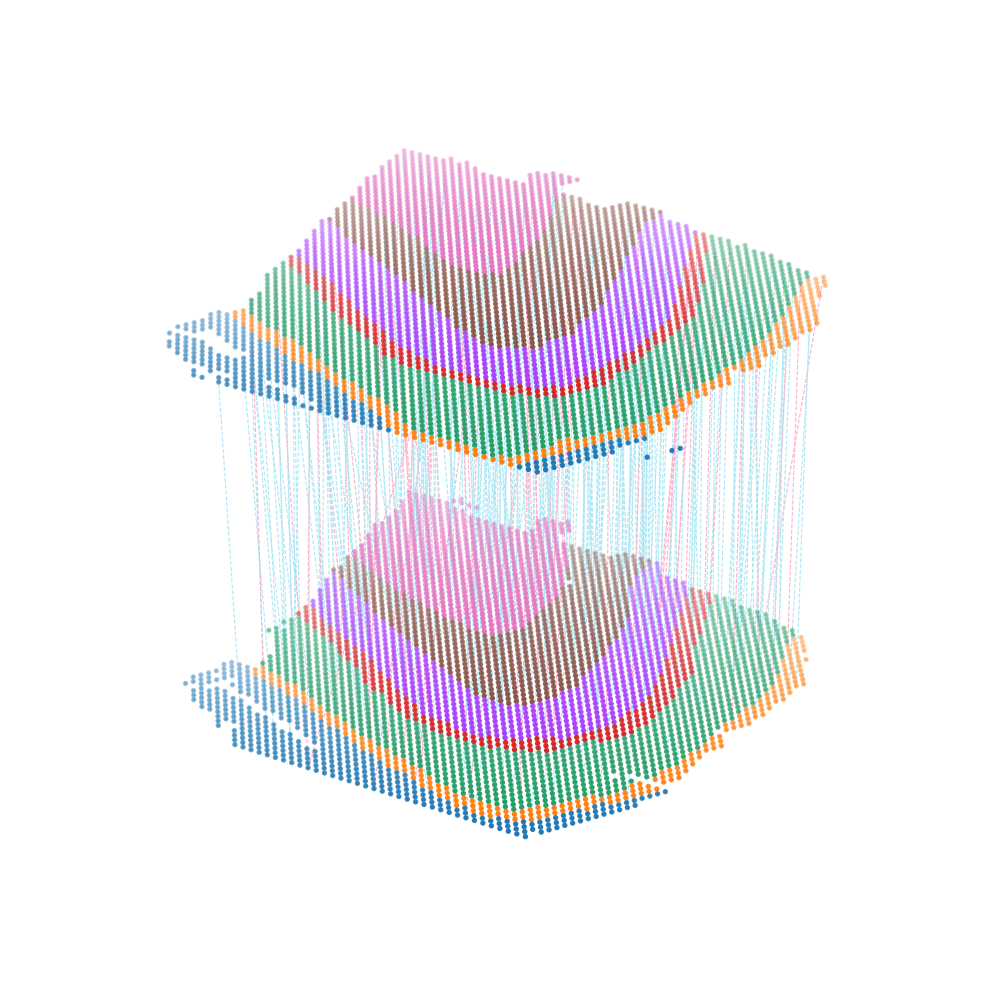

In [9]:
from aligndg.utils.visualize import Build3D

index_harm = np.array(ref_raw_list) 
matching_harm = np.array([range(index_harm.shape[0]), index_harm])

multi_align = Build3D(adata2_harm_df, adata1_harm_df, matching_harm, meta='domain', scale_coordinate=True, subsample_size=300, exchange_xy=False)
multi_align.draw_3D(size=[8, 8], line_width=0.5, point_size=[2, 2], hide_axis=True, show_error=True, line_alpha=1)

In [10]:
def get_ratio_unbalanced(alignment, labels):
    matched_idx_list = []
    ad1_match_label = []
    ad2_match_label = [2] * alignment.shape[1]

    # 确定共有的cell types
    unique_labels_slice1 = set(labels[:alignment.shape[0]])
    unique_labels_slice2 = set(labels[alignment.shape[0]:])
    common_labels = unique_labels_slice1.intersection(unique_labels_slice2)

    # 过滤出只属于共有cell types的索引
    indices_slice1 = [i for i in range(alignment.shape[0]) if labels[i] in common_labels]

    for i in indices_slice1:
        elem = alignment[i]
        max_idx = elem.argmax()
        # matched_idx_list.append(max_idx)
        matched_idx = max_idx + alignment.shape[0]

        if labels[i] == labels[matched_idx]:
            ad1_match_label.append(1)
            ad2_match_label[max_idx] = 1
            matched_idx_list.append(max_idx)
        else:
            ad1_match_label.append(0)
            ad2_match_label[max_idx] = 0
    return len(indices_slice1) / len(set(matched_idx_list))

In [11]:
adata_cat = adata_list[0].concatenate(adata_list[1])
get_ratio_unbalanced(np.array(pis[0]), labels=adata_cat.obs['layer_guess_reordered'])

1.2764227642276422

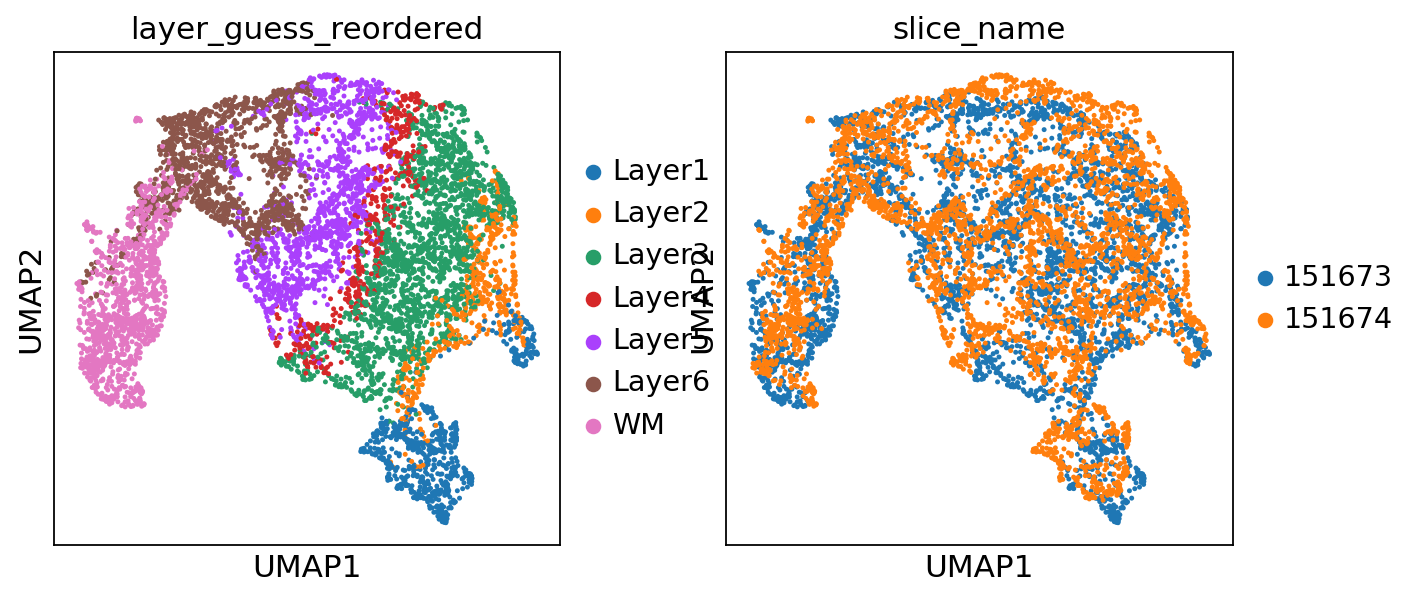

In [12]:
sc.pp.neighbors(adata_concat, use_rep='latent')
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=['layer_guess_reordered', 'slice_name'], size=20)